In [1]:
import numpy as np
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import os
from deepCR.util import maskMetric
from deepCR.dataset import dataset
from skimage.morphology import disk, dilation
from astropy.io import fits
import matplotlib.pyplot as plt
import cv2
import math

In [2]:
def _roc(model, data, thresholds, dilate=None):
    nROC = thresholds.size
    metric = [np.zeros((nROC, 4)), np.zeros((nROC, 4))]
    for t in tqdm(range(len(data))):
        dat = data[t]
        pdt_mask = model.clean(dat[0], inpaint=False, binary=False)
        msk = dat[1]
        ignore = dat[2]
        for i in range(nROC):
            binary_mask = np.array(pdt_mask > thresholds[i]) * (1 - ignore)
            metric[0][i] += maskMetric(binary_mask, msk * (1 - ignore))
            if dilate is not None:
                binary_mask = dilation(binary_mask, dilate)
                metric[1][i] += maskMetric(binary_mask, msk * (1 - ignore))

    TP, TN, FP, FN = metric[0][:, 0], metric[0][:, 1], metric[0][:, 2], metric[0][:, 3]
    TP1, TN1, FP1, FN1 = metric[1][:, 0], metric[1][:, 1], metric[1][:, 2], metric[1][:, 3]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    PUR = TP / (TP + FP)
    PRE = TP / (TP + FP)
    NUM = (TP * TN) - (FP * FN)
    DEN = np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
    MCC = NUM / DEN
    
    TPR1 = TP1 / (TP1 + FN1)
    FPR1 = FP1 / (FP1 + TN1)
    PUR1 = TP1 / (TP1 + FP1)
    PRE1 = TP1 / (TP1 + FP1)
    NUM1 = (TP1 * TN1) - (FP1 * FN1)
    DEN1 = np.sqrt((TP1 + FP1)*(TP1 + FN1)*(TN1 + FP1)*(TN1 + FN1))
    MCC1 = NUM1 / DEN1
    
    return (TP, TN, FP, FN), (TP1, TN1, FP1, FN1)

In [3]:
def _roc_final(model, data, threshold, dilate=None):
    nROC = 1
    metric = [np.zeros((nROC, 4)), np.zeros((nROC, 4))]
    for t in tqdm(range(len(data))):
        dat = data[t]
        pdt_mask = model.clean(dat[0], inpaint=False, binary=False)
        msk = dat[1]
        ignore = dat[2]
        for i in range(nROC):
            binary_mask = np.array(pdt_mask > threshold) * (1 - ignore)
            metric[0][i] += maskMetric(binary_mask, msk * (1 - ignore))
            if dilate is not None:
                binary_mask = dilation(binary_mask, dilate)
                metric[1][i] += maskMetric(binary_mask, msk * (1 - ignore))

    TP, TN, FP, FN = metric[0][:, 0], metric[0][:, 1], metric[0][:, 2], metric[0][:, 3]
    TP1, TN1, FP1, FN1 = metric[1][:, 0], metric[1][:, 1], metric[1][:, 2], metric[1][:, 3]
    
    return (TP, TN, FP, FN), (TP1, TN1, FP1, FN1)

In [4]:
def roc(model, image, mask, ignore=None, sky=None, aug_sky=(0,0), n_mask=1, seed=1, thresholds=np.linspace(0.001, 0.999, 500),
        dilate=False, rad=1):
    kernel = None
    if dilate:
        kernel = disk(rad)
    if type(image) == np.ndarray and len(image.shape) == 3:
        data = dataset(image, mask, ignore, sky, aug_sky)
    elif type(image[0]) == str:
        data = DatasetSim(image, mask, sky=sky, n_mask=n_mask, seed=seed)
    else:
        raise TypeError('Input must be numpy data arrays or list of file paths!')
    (tp, tn, fp, fn), (tp_dilate, tn_dilate, fp_dilate, fn_dilate) = _roc(model, data, thresholds=thresholds, dilate=kernel)
    if dilate:
        return (tp, tn, fp, fn), (tp_dilate, tn_dilate, fp_dilate, fn_dilate)
    else:
        return tp, tn, fp, fn

In [5]:
def roc_final(model, image, mask, ignore=None, sky=None, aug_sky=(0,0), n_mask=1, seed=1, threshold=0.5,
        dilate=False, rad=1):
    kernel = None
    if dilate:
        kernel = disk(rad)
    if type(image) == np.ndarray and len(image.shape) == 3:
        data = dataset(image, mask, ignore, sky, aug_sky)
    elif type(image[0]) == str:
        data = DatasetSim(image, mask, sky=sky, n_mask=n_mask, seed=seed)
    else:
        raise TypeError('Input must be numpy data arrays or list of file paths!')
    (tp, tn, fp, fn), (tp_dilate, tn_dilate, fp_dilate, fn_dilate) = _roc_final(model, data, threshold=threshold, dilate=kernel)
    if dilate:
        return (tp, tn, fp, fn), (tp_dilate, tn_dilate, fp_dilate, fn_dilate)
    else:
        return tp, tn, fp, fn

In [6]:
gc_image = np.load('rg/image.npy')
gc_mask = np.load('rg/mask.npy')
gc_ignore = np.load('rg/ignore.npy')
gc_sky = np.load('rg/sky.npy')

In [7]:
from sharp_model import sharp_base

In [8]:
base_mdl = sharp_base(mask='./base_60.pth', device='CPU', hidden=32, norm='batch', norm_setting=[8,0,True], conv_type='unet', down_type='maxpool', up_type='deconv', sharp=False, deeper=False)
sharp_mdl = sharp_base(mask='./sharp_1_60.pth', device='CPU', hidden=32, norm='batch', norm_setting=[8,0,True], conv_type='unet', down_type='maxpool', up_type='deconv', sharp=True, deeper=False)

In [9]:
th = np.linspace(0.001, 0.999, 100)
aug_sky = (0,0)

In [10]:
tp_base, tn_base, fp_base, fn_base = roc(base_mdl, image=gc_image, mask=gc_mask, ignore=None, sky=None, aug_sky=aug_sky,  thresholds=th)

100%|███████████████████████████████████████| 1050/1050 [05:09<00:00,  3.39it/s]
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:26: RuntimeWarning: invalid value encountered in true_divide
  TPR1 = TP1 / (TP1 + FN1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:27: RuntimeWarning: invalid value encountered in true_divide
  FPR1 = FP1 / (FP1 + TN1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:28: RuntimeWarning: invalid value encountered in true_divide
  PUR1 = TP1 / (TP1 + FP1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:29: RuntimeWarning: invalid value encountered in true_divide
  PRE1 = TP1 / (TP1 + FP1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:32: RuntimeWarning: invalid value encountered in true_divide
  MCC1 = NUM1 / DEN1


In [11]:
tp_sharp, tn_sharp, fp_sharp, fn_sharp = roc(sharp_mdl, image=gc_image, mask=gc_mask, ignore=None, sky=None, aug_sky=aug_sky,  thresholds=th)

100%|███████████████████████████████████████| 1050/1050 [05:06<00:00,  3.43it/s]
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:26: RuntimeWarning: invalid value encountered in true_divide
  TPR1 = TP1 / (TP1 + FN1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:27: RuntimeWarning: invalid value encountered in true_divide
  FPR1 = FP1 / (FP1 + TN1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:28: RuntimeWarning: invalid value encountered in true_divide
  PUR1 = TP1 / (TP1 + FP1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:29: RuntimeWarning: invalid value encountered in true_divide
  PRE1 = TP1 / (TP1 + FP1)
/var/folders/43/6l2p4lvd01z0jjp6pck8jzkw0000gn/T/ipykernel_39420/3739758433.py:32: RuntimeWarning: invalid value encountered in true_divide
  MCC1 = NUM1 / DEN1


In [21]:
tpr_base = tp_base/(tp_base+fn_base)
fpr_base = fp_base/(tn_base+fp_base)
pre = tp_base/(tp_base+fp_base)
Accuracy = (tn_base+tp_base)/(tn_base+tp_base+fn_base+fp_base)
Accuracy_sharp = (tn_sharp+tp_sharp)/(tn_sharp+tp_sharp+fn_sharp+fp_sharp)
tpr_base*=100
fpr_base*=100
pre*=100
Accuracy*=100

tpr_sharp = tp_sharp/(tp_sharp+fn_sharp)
Accuracy_sharp*=100
tpr_sharp*=100

In [22]:
import matplotlib.pyplot as plt

In [23]:
def find_nearest(array, value):
    array = np.asarray(array)
    array = array[array!=0] 
    idx = (np.abs(array - value)).argmin()
    return idx

In [24]:
percent = 1
pre_percent = 85

In [25]:
index = 100

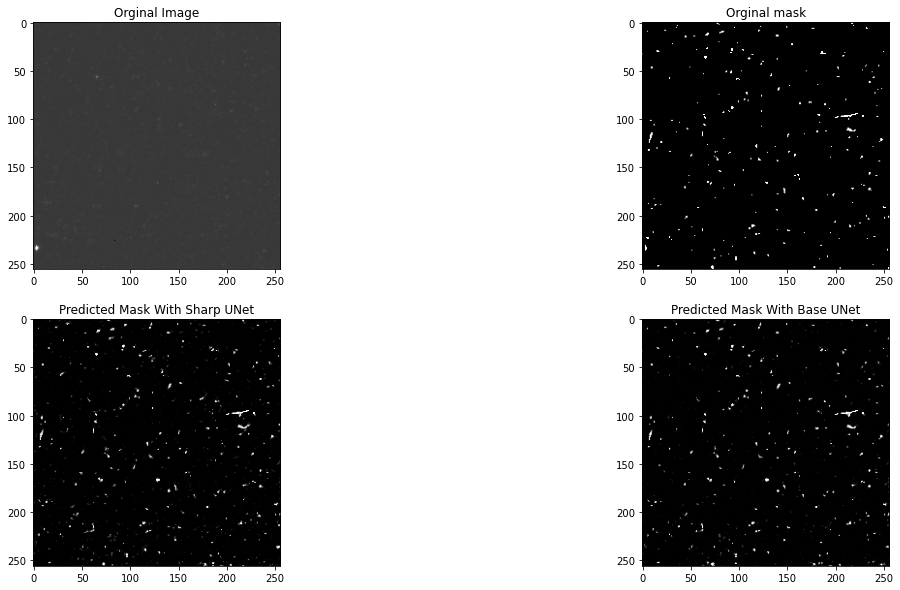

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
pdt_mask_base = base_mdl.clean(gc_image[index], inpaint=False, binary=False)
pdt_mask_sharp = sharp_mdl.clean(gc_image[index], inpaint=False, binary=False)
msk_base = gc_mask[index]
plt.subplot(2,2,1)
plt.title("Orginal Image")
plt.imshow(gc_image[index],cmap='gray')
plt.subplot(2,2,2)
plt.title("Orginal mask")
plt.imshow(msk_base,cmap='gray')
plt.subplot(2,2,3)
plt.title("Predicted Mask With Sharp UNet")
plt.imshow(pdt_mask_sharp,cmap='gray')
plt.subplot(2,2,4)
plt.title("Predicted Mask With Base UNet")
plt.imshow(pdt_mask_base,cmap='gray')
plt.show()

Text(0, 0.5, 'True Positive Rate [%]')

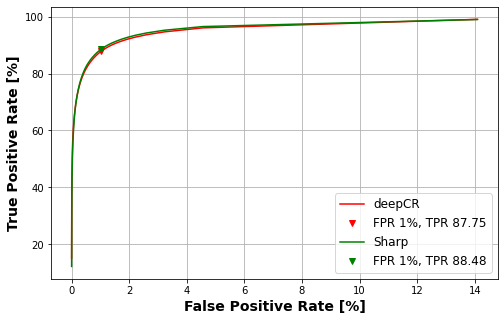

In [27]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(fpr_base,tpr_base,'r', label= "deepCR")
plt.plot(fpr_base[find_nearest(fpr_base, percent)], tpr_base[find_nearest(fpr_base, percent)], 'rv', label=f"FPR {percent}%, TPR "+str("%.2f"%tpr_base[find_nearest(fpr_base, percent)])+"")

plt.plot(fpr_base,tpr_sharp,'g', label= "Sharp")
plt.plot(fpr_base[find_nearest(fpr_base, percent)], tpr_sharp[find_nearest(fpr_base, percent)], 'gv', label=f"FPR {percent}%, TPR "+str("%.2f"%tpr_sharp[find_nearest(fpr_base, percent)])+"")

plt.legend(fontsize=12, loc = "lower right")
plt.grid()
plt.xlabel('False Positive Rate [%]', weight = 'bold', size=14)
plt.ylabel('True Positive Rate [%]', weight = 'bold', size=14)

Text(0, 0.5, 'Precision [%]')

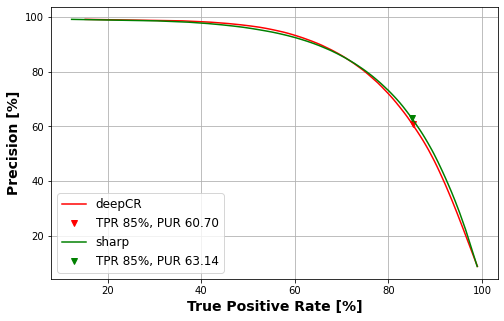

In [28]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(tpr_base,pre, 'r', label= "deepCR")
plt.plot(tpr_base[find_nearest(tpr_base, pre_percent)], pre[find_nearest(tpr_base, pre_percent)], 'rv', label=f"TPR {pre_percent}%, PUR "+str("%.2f"%pre[find_nearest(tpr_base, pre_percent)])+"")

plt.plot(tpr_sharp,pre, 'g', label= "sharp")
plt.plot(tpr_sharp[find_nearest(tpr_sharp, pre_percent)], pre[find_nearest(tpr_sharp, pre_percent)], 'gv', label=f"TPR {pre_percent}%, PUR "+str("%.2f"%pre[find_nearest(tpr_sharp, pre_percent)])+"")

plt.legend(fontsize=12)
plt.grid()
plt.xlabel('True Positive Rate [%]', weight = 'bold', size=14)
plt.ylabel('Precision [%]', weight = 'bold', size=14)

In [29]:
print(f"Accuracy of base model is {np.mean(Accuracy_sharp)}")
print(f"Accuracy of Sharp model is {np.mean(Accuracy)}")

Accuracy of base model is 98.94185155959356
Accuracy of Sharp model is 99.00677637009395
